# Analyzing Metacritic reviews for Ubisoft Games
This is an analysis of games released during the 8th generation of videogames (from 2011 to 2019 from Ubisoft). 

What will be explored?
- Metacritic scores vs User scores
- Scores by genre
- Scores by console

Note: data was extracted from a kaggle dataset. 

# Initial Setup

In [1]:
import pandas as pd # pandas to import csv files
import requests # for performing http requests
from bs4 import BeautifulSoup # for xml and html scraping
import seaborn as sns # importing Seaborne for visualizations
sns.set(style='darkgrid') # Setting style of plots
import matplotlib.pyplot as plt

# Exploring the data

In [2]:
# reading the csv file
games_data = pd.read_csv('./datasets/metacritic_games.csv')
# dataset information (first rows)
games_data.head()

,game,platform,developer,genre,number_players,rating,release_date,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score
0,Portal 2,PC,Valve Software,Action,NaN,E10+,"Apr 18, 2011",51,1,0,1700,107,19,95,90
1,The Elder Scrolls V: Skyrim,PC,Bethesda Game Studios,Role-Playing,No Online Multiplayer,M,"Nov 10, 2011",32,0,0,1616,322,451,94,82
2,The Legend of Zelda: Ocarina of Time 3D,3DS,GREZZO,Miscellaneous,No Online Multiplayer,E10+,"Jun 19, 2011",84,1,0,283,20,5,94,90
3,Batman: Arkham City,PC,Rocksteady Studios,Action Adventure,NaN,T,"Nov 21, 2011",27,0,0,240,34,27,91,87
4,Super Mario 3D Land,3DS,Nintendo,Action,No Online Multiplayer,E,"Nov 13, 2011",81,1,0,251,39,11,90,84


In [3]:
# dataset information (last rows)
games_data.tail()

,game,platform,developer,genre,number_players,rating,release_date,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score
5694,Modern Combat: Blackout,Switch,Gameloft,Action,No Online Multiplayer,NaN,"Feb 14, 2019",0,5,2,1,0,1,53,57
5695,Fimbul,PS4,Zaxis,Action Adventure,No Online Multiplayer,NaN,"Feb 28, 2019",0,7,2,1,0,0,52,18
5696,Generation Zero,PC,Avalanche Studios,Action Adventure,Online Multiplayer,T,"Mar 26, 2019",1,11,6,5,2,6,50,57
5697,Vane,PS4,Friend & Foe,Adventure,No Online Multiplayer,E10+,"Jan 15, 2019",3,26,22,2,2,2,49,55
5698,Left Alive,PS4,"Square Enix, ilinx inc.",Action Adventure,No Online Multiplayer,M,"Mar 5, 2019",1,7,27,25,8,21,37,79


In [4]:
columns = games_data.columns
columns

Index(['game', 'platform', 'developer', 'genre', 'number_players', 'rating',
       'release_date', 'positive_critics', 'neutral_critics',
       'negative_critics', 'positive_users', 'neutral_users', 'negative_users',
       'metascore', 'user_score'],
      dtype='object')

In [5]:
# get shape of the data
games_data.shape

(5699, 15)

In [6]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5699 entries, 0 to 5698
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   game              5699 non-null   object
 1   platform          5699 non-null   object
 2   developer         5685 non-null   object
 3   genre             5694 non-null   object
 4   number_players    3059 non-null   object
 5   rating            4433 non-null   object
 6   release_date      5699 non-null   object
 7   positive_critics  5699 non-null   int64 
 8   neutral_critics   5699 non-null   int64 
 9   negative_critics  5699 non-null   int64 
 10  positive_users    5699 non-null   int64 
 11  neutral_users     5699 non-null   int64 
 12  negative_users    5699 non-null   int64 
 13  metascore         5699 non-null   int64 
 14  user_score        5699 non-null   int64 
dtypes: int64(8), object(7)
memory usage: 668.0+ KB


### Let's check if there are missing values in the columns we are interested in. 

In [7]:
games_data.loc[:, games_data.isnull().any()].columns

Index(['developer', 'genre', 'number_players', 'rating'], dtype='object')

### Since we want to analyze the data from an specific developer, we cannot simply drop all the titles that have any missing values (ie. df.dropna())

### We need to compare the list of titles with missing values in the developer column against a list of all the Ubisoft games released between 2011 and 2019. 

In [8]:
# storing wikipedia url which contains a table with all ubisoft games
# released between 2010 and 2019
url = 'https://en.wikipedia.org/wiki/List_of_Ubisoft_games:_2010%E2%80%932019'
session = requests.Session()
response = session.get(url, timeout=10).text
# parsing the text with BeautifulSoup
soup = BeautifulSoup(response, 'lxml')
# Creating empty list to append all titles' names
ubi_titles = []
# looping through all the elements of the table to extract only titles
for items in soup.find('table', class_='wikitable sortable').find_all('tr')[1::1]:
    data = items.find_all(['th', 'td'])
    try:
        title = data[0].text.rstrip()
    except IndexError:pass
    ubi_titles.append(title)

# To check that the scraping process worked, let's retieve the first 5 elements.
print(ubi_titles[0:5])

["Assassin's Creed II: Discovery", 'Sleepover Party', 'No More Heroes 2: Desperate Struggle', 'Battle of Giants: Mutant Insects', "Assassin's Creed II"]


### Next, we check if any of the titles that have a missing developer are present in the list of games released by ubisoft. 

In [9]:
games_data[games_data.developer.isnull()].game.isin(ubi_titles)

258     False
620     False
1103    False
1129    False
1434    False
1562    False
1609    False
1727    False
1818    False
1901    False
2262    False
3500    False
4192    False
5520    False
Name: game, dtype: bool

### Indeed, we can confirm that there are no titles from Ubisoft with missing values, so we can proceed to clean the data by dropping all the NaN values.

# Cleaning and transforming the Data

In [10]:
# dropping all the NaN values.
games_data = games_data.dropna()
# Filtering dataframe by Ubisoft titles and sotring it in a new variable
ubisoft_dataframe = games_data[games_data['developer'].str.contains('Ubisoft')]
ubisoft_dataframe

,game,platform,developer,genre,number_players,rating,release_date,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score
81,From Dust,PC,Ubisoft Montpellier,Strategy,1 Player,E10+,"Aug 17, 2011",10,5,0,38,41,83,76,49
223,Rabbids Travel in Time 3D,3DS,Ubisoft,Action,1 Player,E,"Apr 10, 2011",1,20,5,2,4,0,55,62
235,Tom Clancy's Splinter Cell 3D,3DS,Ubisoft,Action Adventure,No Online Multiplayer,T,"Apr 10, 2011",1,21,10,2,1,2,53,57
281,Far Cry 3,PC,Ubisoft Montreal,Action,Up to 4,M,"Dec 4, 2012",42,1,0,465,116,87,88,83
298,Assassin's Creed III,WIIU,Ubisoft Quebec,Action Adventure,Up to 8,M,"Nov 18, 2012",25,1,0,27,10,2,85,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5312,The Crew 2,PC,Ubisoft Ivory Tower,Racing,Up to 8,T,"Jun 28, 2018",5,15,1,5,6,22,66,44
5340,The Crew 2,PS4,Ubisoft Ivory Tower,Racing,Up to 8,T,"Jun 26, 2018",14,38,1,21,12,27,64,50
5610,Far Cry New Dawn,XONE,Ubisoft Montreal,Action,2,M,"Feb 15, 2019",17,9,0,6,3,7,75,31
5625,Far Cry New Dawn,PC,Ubisoft Montreal,Action,Online Multiplayer,M,"Feb 15, 2019",13,11,0,24,31,65,73,34


# Visualazing the Data

## Scatterplot
### We can see there is a positive correlation between the metacritic score and the users score in most of the genres.
### However, we can see some outliers in the action and action adventure, where high metacritic scores does not necessarily means high user scores. 
### Next, lest's corroborate if that's the case getting the top 10 most beloved games by critics which were not well received by users.

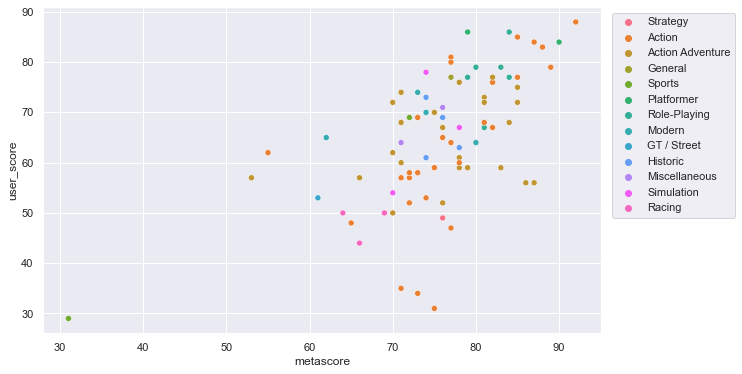

In [11]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=ubisoft_dataframe, x='metascore', y='user_score', hue='genre')
plt.legend(bbox_to_anchor=(1.01, 1))

In [15]:
ubisoft_dataframe.loc[:, 'score_diff'] = ubisoft_dataframe['metascore'] - ubisoft_dataframe['user_score']
ubisoft_dataframe.sort_values('score_diff', ascending=False).head(10)

,game,platform,developer,genre,number_players,rating,release_date,positive_critics,neutral_critics,negative_critics,positive_users,neutral_users,negative_users,metascore,user_score,score_diff
5610,Far Cry New Dawn,XONE,Ubisoft Montreal,Action,2,M,"Feb 15, 2019",17,9,0,6,3,7,75,31,44
5625,Far Cry New Dawn,PC,Ubisoft Montreal,Action,Online Multiplayer,M,"Feb 15, 2019",13,11,0,24,31,65,73,34,39
5635,Far Cry New Dawn,PS4,Ubisoft Montreal,Action,2,M,"Feb 15, 2019",34,34,1,33,15,46,71,35,36
4558,Assassin's Creed Odyssey,XONE,Ubisoft,Action Adventure,No Online Multiplayer,M,"Oct 2, 2018",34,0,0,58,12,17,87,56,31
4867,Just Dance 2019,XONE,Ubisoft Paris,Action,No Online Multiplayer,E,"Oct 23, 2018",7,1,0,1,0,0,77,47,30
4583,Assassin's Creed Odyssey,PC,Ubisoft,Action Adventure,No Online Multiplayer,M,"Oct 2, 2018",13,1,0,127,27,104,86,56,30
81,From Dust,PC,Ubisoft Montpellier,Strategy,1 Player,E10+,"Aug 17, 2011",10,5,0,38,41,83,76,49,27
4671,Assassin's Creed Odyssey,PS4,Ubisoft,Action Adventure,No Online Multiplayer,M,"Oct 2, 2018",73,13,0,194,59,126,83,59,24
3934,For Honor,PC,Ubisoft Montreal,Action Adventure,Online Multiplayer,M,"Feb 13, 2017",20,11,0,70,40,97,76,52,24
5312,The Crew 2,PC,Ubisoft Ivory Tower,Racing,Up to 8,T,"Jun 28, 2018",5,15,1,5,6,22,66,44,22


### Indeed, most of the games that have a high value for difference in scores are Action / Action adventures games.

## Bar Charts: Visualizing top platforms for Ubisoft in this generation (by average scores by platform - metascores and users)

In [18]:
by_platform = ubisoft_dataframe.groupby('platform')['metascore', 'user_score'].mean()

<ipython-input-18-35f36683ef31>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_platform = ubisoft_dataframe.groupby('platform')['metascore', 'user_score'].mean()


<AxesSubplot:xlabel='platform', ylabel='metascore'>

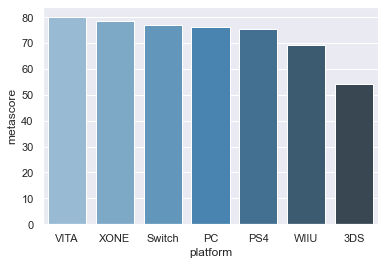

In [19]:
by_platform = by_platform.sort_values('metascore', ascending=False)
sns.barplot(x=by_platform.index, y=by_platform.metascore, palette='Blues_d')

<AxesSubplot:xlabel='platform', ylabel='user_score'>

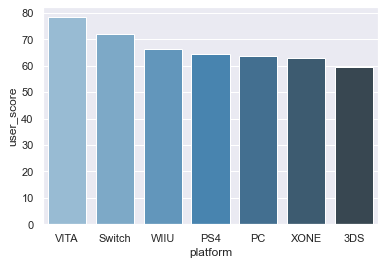

In [20]:
by_platform = by_platform.sort_values('user_score', ascending=False)
sns.barplot(x=by_platform.index, y=by_platform.user_score, palette='Blues_d')

### We can see a difference between both graphs.
### Even though there is not much of a difference between the averages scores by platform; users were more generous with WiiU and PS4 scores and slighly less generous with XONE and PC compared to the metacritics scores. 